In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For inline plotting in Jupyter Notebook
%matplotlib inline

/Users/naveenbaskar/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Data Loading

df_tourism = pd.read_csv('/Users/naveenbaskar/Desktop/archive/tourism_with_id.csv')
df_ratings = pd.read_csv('/Users/naveenbaskar/Desktop/archive/tourism_rating.csv')
df_packages = pd.read_csv('/Users/naveenbaskar/Desktop/archive/package_tourism.csv')
df_users = pd.read_csv('/Users/naveenbaskar/Desktop/archive/user.csv')

In [3]:
df_tourism = df_tourism.loc[:, ~df_tourism.columns.str.contains('^Unnamed')]

# Check for missing values and decide on imputation or removal
print("Missing values in tourism dataset:")
print(df_tourism.isnull().sum())

Missing values in tourism dataset:
Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
dtype: int64


In [4]:
# For demonstration, you might fill missing numeric values with the median:
df_tourism['Time_Minutes'] = df_tourism['Time_Minutes'].fillna(df_tourism['Time_Minutes'].median())

In [5]:
# Summary statistics
print(df_tourism.describe())

         Place_Id          Price      Rating  Time_Minutes         Lat  \
count  437.000000     437.000000  437.000000    437.000000  437.000000   
mean   219.000000   24652.173913    4.442792     70.606407   -7.095438   
std    126.295289   66446.374709    0.208587     37.889092    0.727241   
min      1.000000       0.000000    3.400000     10.000000   -8.197894   
25%    110.000000       0.000000    4.300000     60.000000   -7.749590   
50%    219.000000    5000.000000    4.500000     60.000000   -7.020524   
75%    328.000000   20000.000000    4.600000     60.000000   -6.829411   
max    437.000000  900000.000000    5.000000    360.000000    1.078880   

             Long  
count  437.000000  
mean   109.160142  
std      1.962848  
min    103.931398  
25%    107.578369  
50%    110.237468  
75%    110.431869  
max    112.821662  


/Users/naveenbaskar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


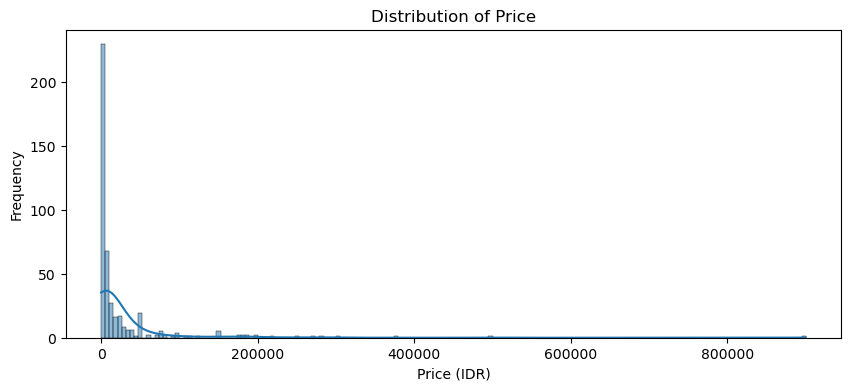

In [6]:
plt.figure(figsize=(10,4))
sns.histplot(df_tourism['Price'], kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price (IDR)')
plt.ylabel('Frequency')
plt.show()

/Users/naveenbaskar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


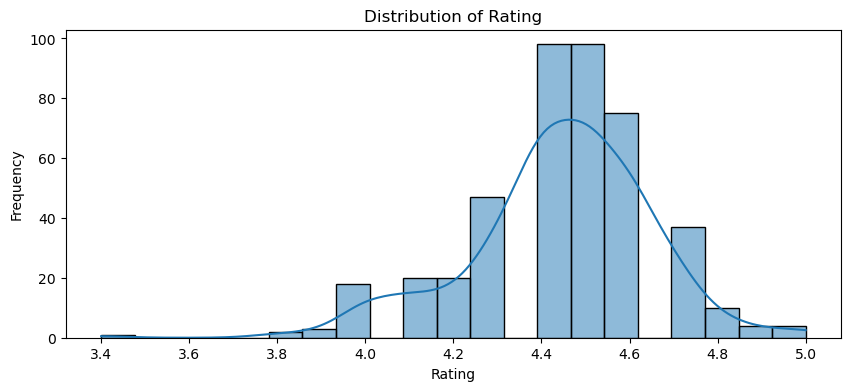

In [7]:
plt.figure(figsize=(10,4))
sns.histplot(df_tourism['Rating'], kde=True)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

/Users/naveenbaskar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


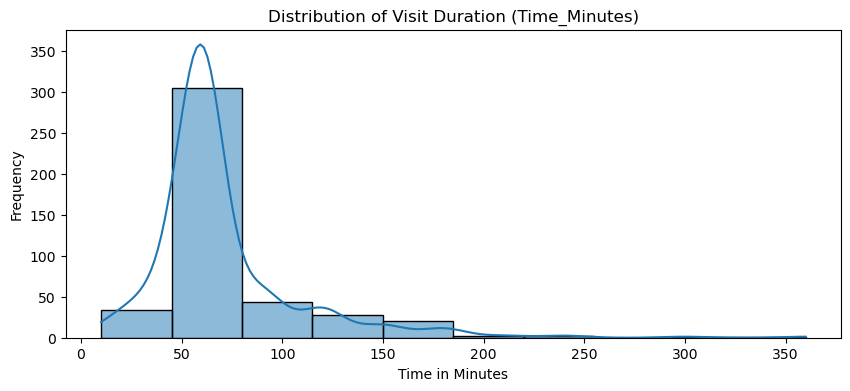

In [8]:
plt.figure(figsize=(10,4))
sns.histplot(df_tourism['Time_Minutes'], kde=True)
plt.title('Distribution of Visit Duration (Time_Minutes)')
plt.xlabel('Time in Minutes')
plt.ylabel('Frequency')
plt.show()

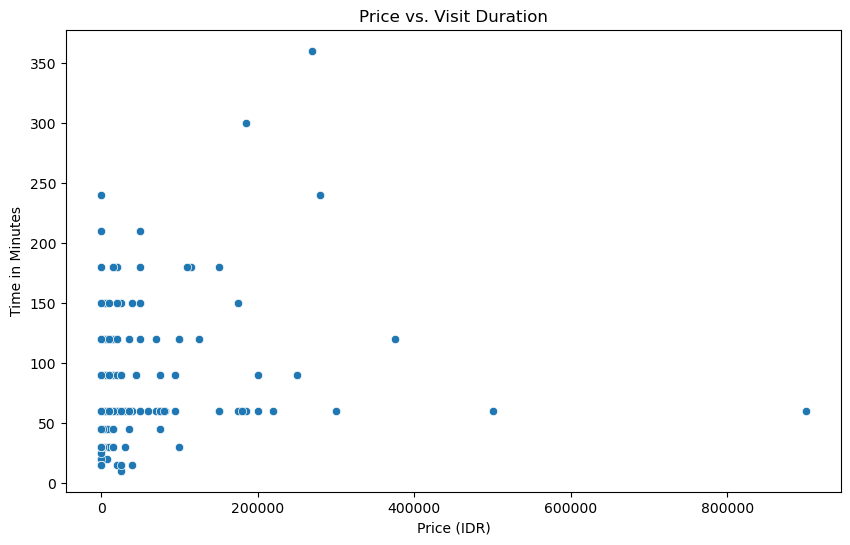

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_tourism, x='Price', y='Time_Minutes')
plt.title('Price vs. Visit Duration')
plt.xlabel('Price (IDR)')
plt.ylabel('Time in Minutes')
plt.show()

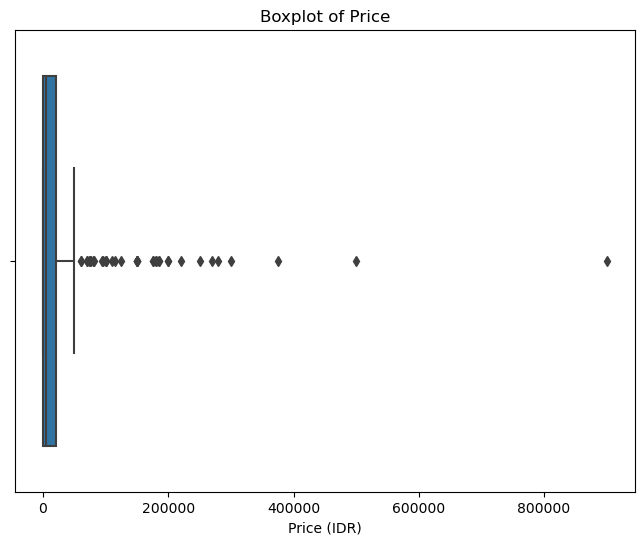

In [10]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df_tourism['Price'])
plt.title('Boxplot of Price')
plt.xlabel('Price (IDR)')
plt.show()

In [12]:
# Select only numeric columns
numeric_df = df_tourism.select_dtypes(include=[np.number])

# Now compute the correlation matrix on the numeric columns only
corr_matrix = numeric_df.corr()

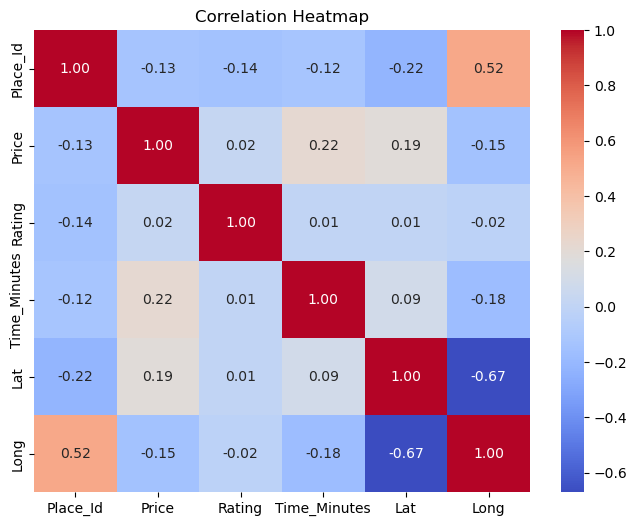

In [13]:
# Heatmap for visualizing correlations among features
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

/Users/naveenbaskar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/naveenbaskar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/naveenbaskar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/naveenbaskar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

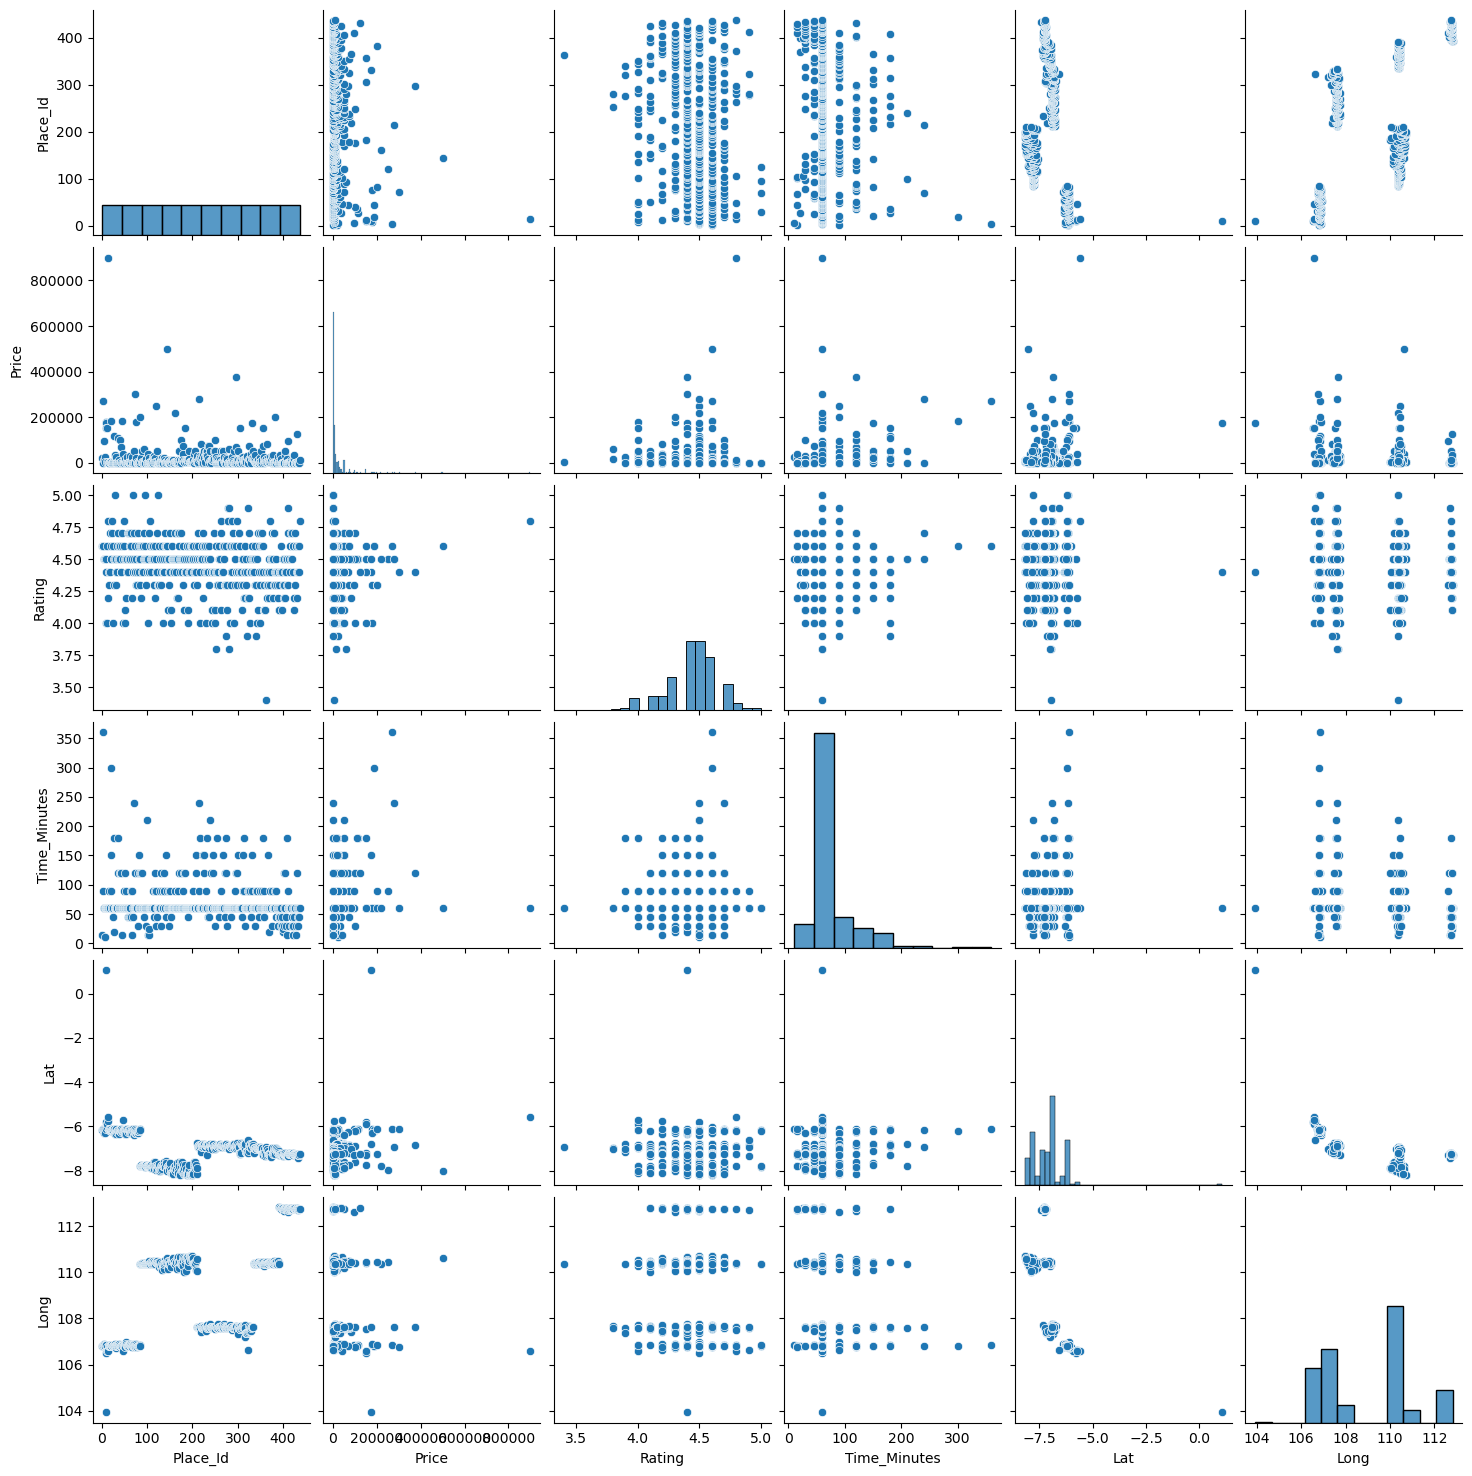

In [14]:
# Pairplot to visualize relationships between multiple features
sns.pairplot(df_tourism)
plt.show()